# Debugging Conv Nets

## Introducere

Unul dintre dezavantajele rețelelor neurale, în general, este dificultatea cu care se poate explica de ce un model face anumite predicții. Se spune că sunt ca niște "cutii negre" (eng. "black box") pentru că ceea ce învață este greu de reprezentat într-o formă ușor de înțeles pentru oameni. Cu toate acestea, pentru rețele convoluționale, cercetătorii au dezvoltat o serie de tehnici pentru "a vedea" în interiorul unui model antrenat. 

În laboratorul de față vom explora 3 dintre aceste metode, care sunt accesibile și utile:
- **Vizualizare ieșirilor intermediare (activări intermediare)** dintr-o rețea conv net. Este utilă pentru a înțelege cum procesează straturile succesive imagine de intrare
- **Vizualizarea filtrelor (kernels)** dintr-o rețea conv net. Este utilă pentru a vedea și a înțelege la ce caracteristici vizuale este sensibil/receptiv un filtru
- **Vizualizarea sub formă de heatmap a activărilor unei clase într-o imagine de intrare**. Această metodă este utilă pentru a identificare care porțiuni dintr-o imagine de intrare au fost identificare ca făcând parte dintr-o anumită clasă

## Setup

Pentru toate cele 3 metode vom importa pachetele necesare, precum și funcțiile de pre-procesare a imaginii de intrare și cele de decodare a predicțiilor. Vom folosi ca și exemply rețeau VGG16, care este definită în keras.

In [76]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model , load_model
from tensorflow import keras
from IPython.display import Image, display

In [77]:
def get_img_array(img_path, size):
    """
    Return a numpy array containing the image read from
    `img_path` and resized to `size`
    Args:
        img_path (str): path to image
        size (tuple): desired dimension for the image

    Returns:
        [numpy.ndarray]: the loaded image
    """
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [78]:
# Pentru ușurință se asignează unor variabile clasa care creează rețeaua convnet
# și funcțiile de pre-procesare și decodare asociate acesteia.
# network = keras.applications.vgg16.VGG16
# preprocess_input = keras.applications.vgg16.preprocess_input
# decode_predictions = keras.applications.vgg16.decode_predictions
# # dimensiunea imaginiilor cu care a fost antrenată rețeaua pe setul de date ImageNet
# # pentru VGG16, este (224, 224)
# img_size = (224, 224) 


img_size = (128, 128) 

## Vizualizare ieșirilor intermediare (activări intermediare)

Această metodă constă în afișarea hărților de trăsături (eng. feature maps) care sunt generate de straturile de convoluție sau pooling după procesarea unei imagini de intrare. Ieșirea unui strat se mai numește activare (eng. activation) pentru că este rezultatul funcție de activare). Vizualizând feature maps putem observa cum imaginea de intrare este descompusă și procesată de fiecare filtru învățat de rețea. Fiecare feature maps are 3 dimensiuni: lățime, înălțime și adâncime (canale), unde fiecare canal reprezintă o singură hartă de trăsături _distinctă_.

Astfel că pentru a vizuliza aceste features map, tot ce trebuie să facem este să trecem o imagine de intrare printr-o rețea antrenată și să extragem activările intermediare și a le afișa ca pe o imagine.

In [79]:
# Încărcăm o rețea deja antrenată, fie una care există în keras fie una antrenată de noi
# model = network(weights='imagenet')
model = keras.models.load_model(r"D:\ai intro\Munca_v2\Experimente Confusion Matrix\big dataset\13\damn2020_12142021.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


float32 0.0 0.93725497


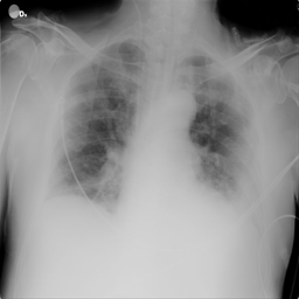

In [80]:
# Încărcăm o imagine și o procesăm cu funcția din variabila
# preprocess_inpu
test_img = get_img_array("COVID-1.png", img_size)
# test_img = preprocess_input(test_img)
test_img *= 1/255.
print(test_img.dtype, test_img.min(), test_img.max())

# Pentru a o afișa vom folosi funcția display din IPython
# care încarcă din nou imaginea de pe disk într-un alt tip de obiect
display(Image("COVID-1.png", width=400, height=400))

Pentru a extrage feature maps vom construi un model keras care primește la intrare imaginea de mai sus și ca ieșire for fi activările de la toate straturile convoluționale și de pooling. `Model` va fi instanțiat cu două argumente: un tensor de intrare (sau o listă de tensori) și un tensor (sau o listă de tensori) de ieșire. Spre deosebire de clasa `Sequential` din keras, acest obiect permitea crearea unor modele cu mai multe ieșiri.

In [44]:
model.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'vgg16_input')>

In [45]:
layer_outputs = [layer.output for layer in model.get_layer('vgg16').layers]
activation_model = keras.models.Model(inputs=model.get_layer('vgg16').input, outputs=layer_outputs)

Imaginea de intrare este trecută prin model cu funcția `predict`. Pentru modelul are mai multe ieșiri, acestea vor fi salvate într-o listă, unde fiecare element este un tensor cu dimensiunea ieșiri stratului corespunzător

In [46]:
activations = activation_model.predict(test_img)
print("nr activations:", len(activations))

# stratul de pe poziția 0 este de tip Input, care nu are feature maps,
# fiind folosit pentru a instanția un tensor Keras
first_layer_activation = activations[1] 

# Pentru VGG16 primul strat convoluțional generează un feature map cu 64 de canale
print(type(first_layer_activation), first_layer_activation.shape)

nr activations: 19
<class 'numpy.ndarray'> (1, 128, 128, 64)


În exemplul de mai jos, se afișează canalul al 12-lea, adică ieșirea filtrului 12 din primul strat. Acesta are un răspuns mai puternic la ochii pisicii: filtrul a învățat să detecteze ochi de pisică.

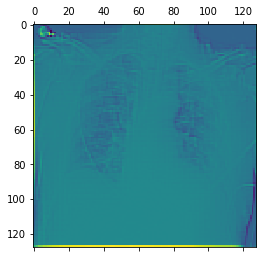

In [47]:
plt.matshow(first_layer_activation[0, :, :, 12], cmap='viridis')

În continuare vom afișa fiecare activare din rețea, extrăgând fiecare canal din toate features maps și apoi vor fi aranjate într-o singură imagine

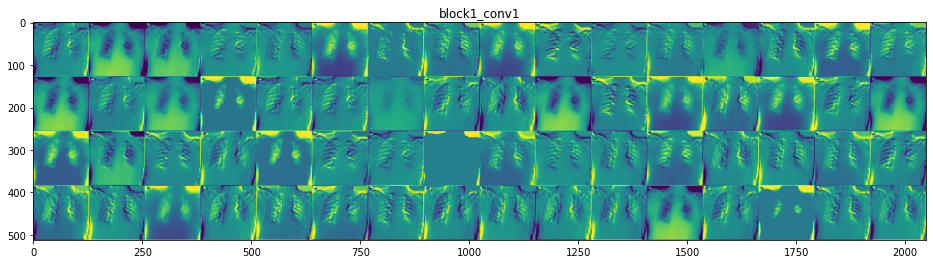

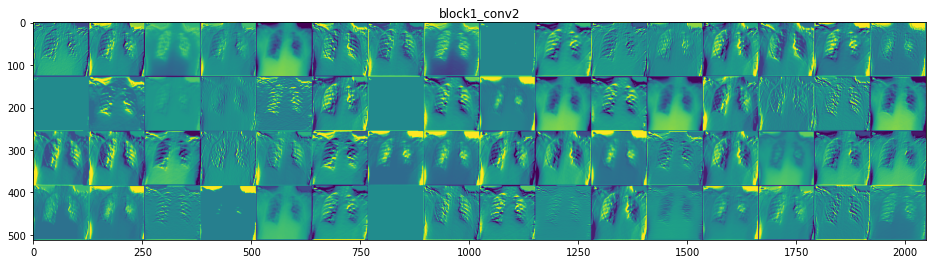

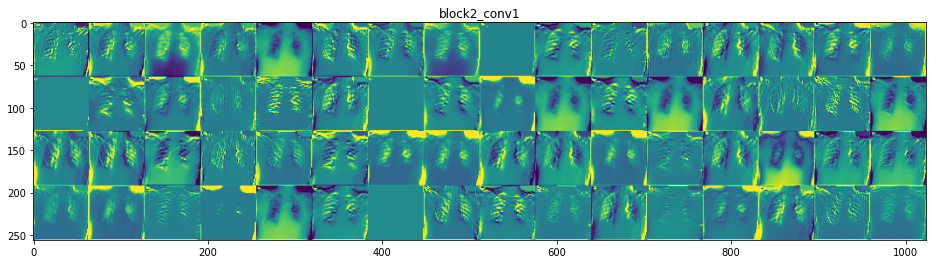

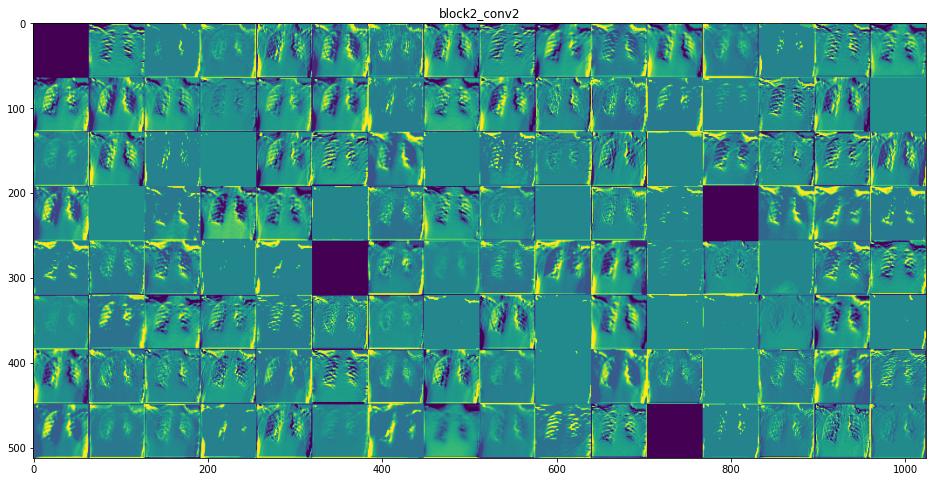

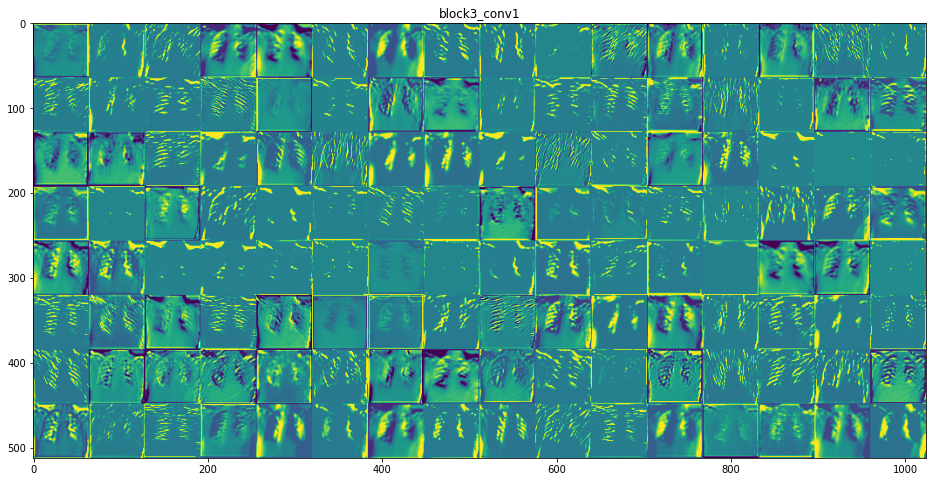

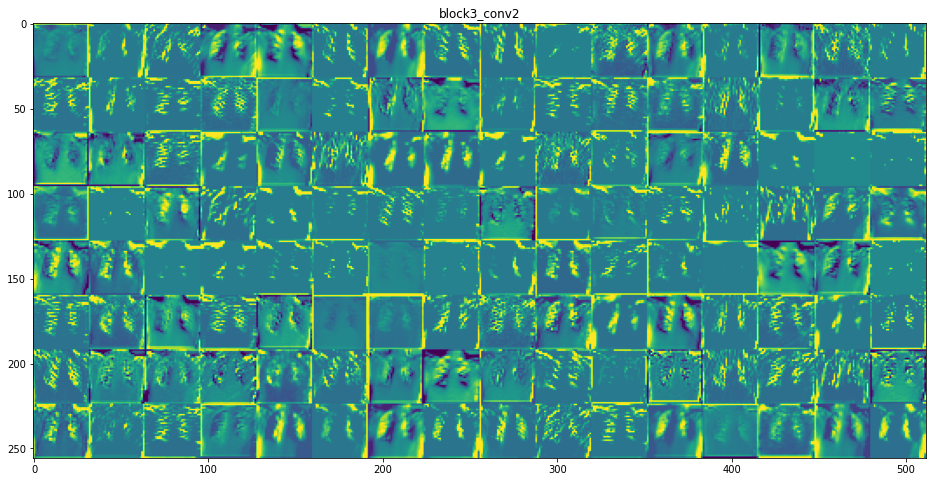

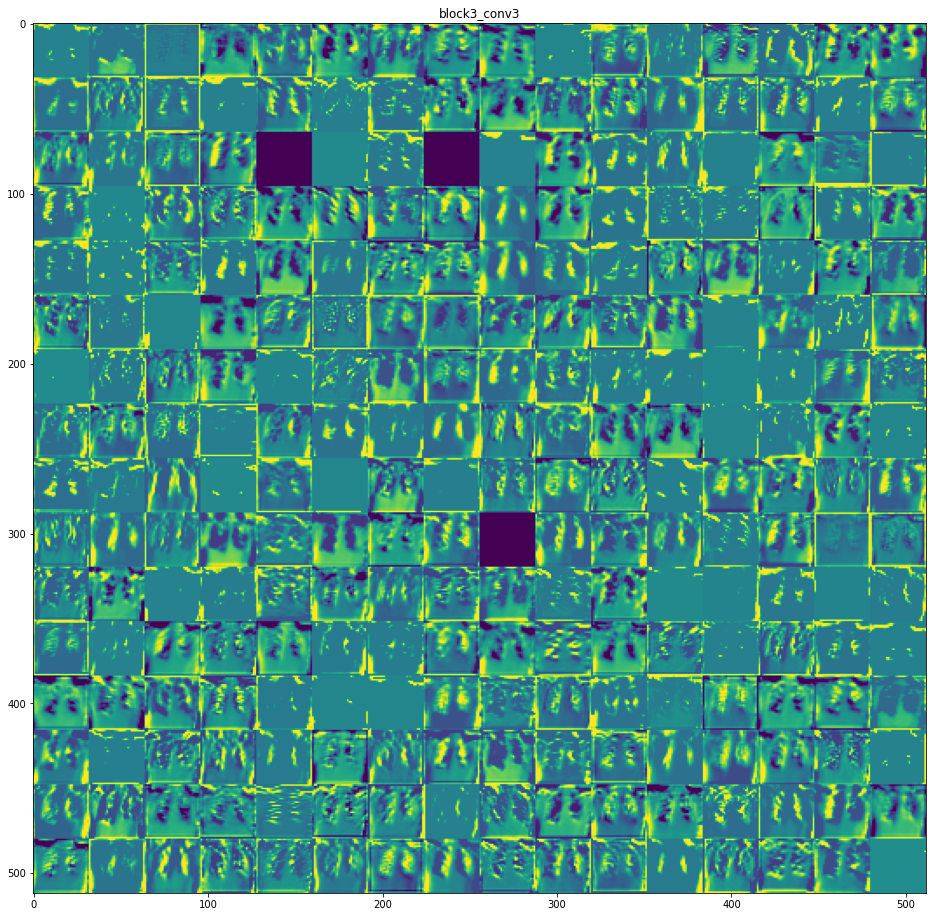

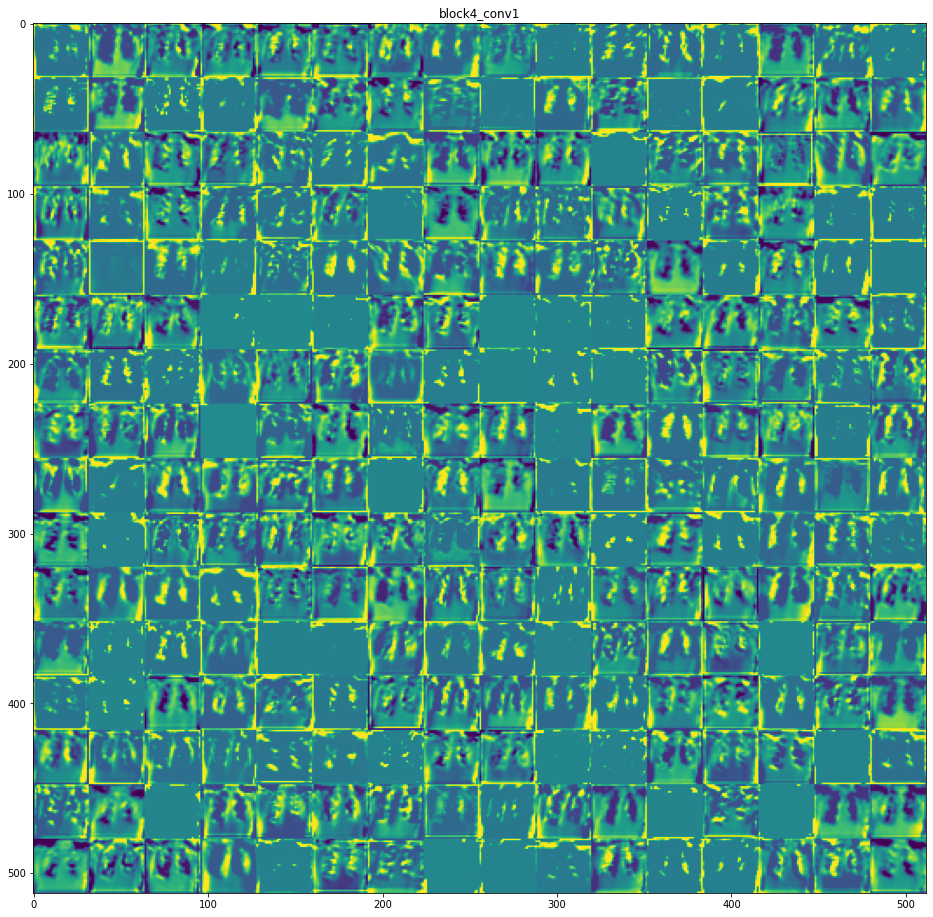

In [48]:
layer_names = []
max_nr_layers = 8
for layer in model.get_layer('vgg16').layers:
    # am ignorat aici straturile de input, pooling și flatten, insă pot fi afișate și ele
    if "input" not in layer.name and "pool" not in layer.name and "flatten" not in layer.name:
        layer_names.append(layer.name)
    if len(layer_names) == max_nr_layers:
        break

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations[1:]):
    # nr total de features intr-un feature map
    n_features = layer_activation.shape[-1]

    # dimensiunea unui feature map
    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row

    # se crează o imagine care să curprind nr de canale specificat prin images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # se populează grid-ul creat anterior
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0,:, :, channel_index].copy()
            if channel_image.sum() != 0:
                # post-proceseaza imaginea pentru vizualizare
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()

                channel_image *= 64
                channel_image += 128

            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### De reținut
- Primul strat conține mai multe detectoare de cante (eng. edge detectors), păstrând majoritatea informațiilor din imagine;
- Pe măsură ce mergem mai adânc în rețea, hărțile de caracteristici arată mai puțin ca imaginea originală și mai mult ca o reprezentare abstractă a acesteia. Motivul este că hărțile cu caracteristici mai profunde codifică concepte de nivel înalt, cum ar fi „nasul pisicii” sau „urechea câinelui”, în timp ce hărțile cu caracteristici de nivel inferior detectează margini și forme simple. De aceea, hărțile de caracteristici mai profunde conțin mai puține informații despre imagine și mai multe despre clasa imaginii. Acestea încă codifică caracteristici utile, dar sunt mai puțin interpretabile vizual de către noi.
- Hărțile cu caracteristici devin mai goale pe măsură ce coborăm mai adânc în rețea, ceea ce înseamnă că filtrele detectează mai puține caracteristici. Acest lucru se explică prin faptul că filtrele din primele straturi detectează forme simple pe care fiecare imagine le conține. Pe măsură ce mergem mai adânc începem să căutăm lucruri mai complexe precum „coada câinelui” și acestea nu apar în fiecare imagine. De aceea vedem mai multe hărți de caracteristici goale pe măsură ce mergem mai adânc.

O rețea conv net distilează informația, procesând o imagine și succesiv îndepărtând informația irelevantă, în timp ce informația utilă este amplificată.

## Vizualizarea filtrelor (kernels)

A doua metodă presupune inspectarea filtrelor învățate de rețea prin generarea și afișarea trăsăturilor la care ar trebui să răspundă fiecare filtru. Mai precis, se pornește de la o imagine cu valori aleatorii și se folosește algoritmul de *gradient descent* pentru a **maximiza** răspunsul/ieșirea unui anumit filtru. Acest proces se mai numește *gradient ascent in input space*. Imaginea astfel rezultată va fi una pentru care un anumit filter va avea un răspuns maxim.

Vom încărca din nou modelul VGG16, dar fără straturile fully-conected, `include_top=False`. Alegem un strat din rețea și folosind aceeași clasă `Model` ca în metoda anterioră, creem un model, denumit feature extractor.

Dacă vă mai aduceți aminte, o rețea convoluțională pentru clasificare este formată dintr-un feature extractor și un clasificator.

In [49]:
layer_name = 'block1_conv1'


# Set up a model that returns the activation values for our target layer
# model = network(weights='imagenet', include_top=False)
print(model.summary())

layer = model.get_layer('vgg16').get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.get_layer('vgg16').inputs, outputs=layer.output)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [50]:
layer.output.shape

TensorShape([None, 128, 128, 64])

Această funcție calculează "loss-ul" unui anumit filtru, care reprezintă de fapt media activărilor unui filtru.

In [51]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

Următoarea funcție calculează gradienții funcției loss în funcție de imaginea de intrare și modifică această imagine astfel încât să activeze cât mai mult un filtru. Gradienții sunt normalizați cu L2 norm:
$$\left(\sum_i^N{|x_i|^2}\right)^{1/2} = \sqrt{x_1^2 + x_2^2 + ... + x_N^2}$$

Acest lucru asigură că magnitudinea modificărilor la imaginea de intrare sunt întotdeauna în același interval.

In [52]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

Procesul este după cum urmează:
- se pornește de la o imagine cu valori aleatoare - "all gray"
- se aplică în mod repetat algoritmul de gradient ascent definit prin funcția de mai sus
- se convertește imaginea rezultată astfel încât să se poată afișa

In [53]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1,  img_size[1], img_size[0], 3))
    # VGG16 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 30 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

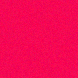

In [54]:
# se afișiează filtrul 5 din stratul definit prin layer_name
idx = 5
loss, img = visualize_filter(idx)
filter_path = f"{layer_name}_{idx}.png"
keras.preprocessing.image.save_img(filter_path, img)
display(Image(filter_path))

Următoarele linii de cod generează un grid de 8x8 pentru a afișa primele 64 de filtre din strat și a vedea trăsăturile pe care modelul le-a învățat

100%|██████████| 32/32 [00:20<00:00,  1.54it/s]


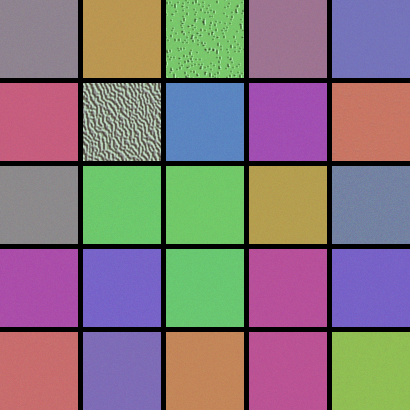

In [55]:
from tqdm import tqdm
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in tqdm(range(32)):
    # print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 5
cropped_width = img_size[1] - 25 * 2
cropped_height = img_size[0] - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img

stiched_path = f"{layer_name}_stiched_filters.png"
keras.preprocessing.image.save_img(stiched_path, stitched_filters)

display(Image(stiched_path))

Primul strat, `block1_conv1` encodează cante și culori, iar `block2_conv1` a învățat diferite texturi din combinarea culorilor și a cantelor. Filtrele din straturile mai adânci se aseamănă cu trăsături găsite în realitate: ochi, frunze, șa.

##  Vizualizarea sub formă de heatmap a activărilor unei clase într-o imagine de intrare. Grad-CAM

Ultima metodă este și cea mai interesantă și utilă în a înțelege care regiuni dintr-o imagine au dus la o anumită decizie de clasificare. Acest lucru este de ajutor mai ales în cazul greșelilor de clasificare, când rețeaua confundă anumite clase între ele. De asemenea, este ajutor în localizarea unui obiect în imagine.

Această metodă este doar una din categoria de tehnici denumite *class activation map (CAM)*. Presupune generarea unei hărți (heatmap) cu activările unei clase suprapuse peste imaginea de intrare. Class activation map reprezintă un grid 2D de scoruri asociate cu o anumită clasă de ieșire, calculate pentru fiecare locație în funcție de clasa considerată. Spre exemplu, pentru o imagine cu un câine trecută printr-o rețea convoluțională care clasifică câini vs pisici, o vizualizare de tip CAM va genera un heatmap pentru clasa "pisică" indicând cât de importante au fost anumite regiuni în prezicerea clasei "pisică".

Implementarea de față este descrisă în articolul ["Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization."](https://arxiv.org/abs/1610.02391)

Acesta constă în următorii pași:
- se ia feature map al unui strat convoluțional (de obicei ultimul strat convoluțional) după ce se trece prin rețea o imagine de intrare
- fiecare canal din feature map este ponderat de gradientul clasei considerate în funcție de canal.

Cu alte cuvinte, se crează o hartă care reprezintă cât de intens activează imaginea de input diferitele canale în funcție de cât de important este fiecare canal pentru clasa specificată. 

Vom încărca din nou rețeau VGG16, de data asta complet.

In [81]:
model_path = r"D:\ai intro\Munca_v2\Experimente Confusion Matrix\big dataset\13\damn2020_12142021.h5"
img_path = 'COVID-1.png'


In [82]:
# Load model that containes a network inside a layer
orig_model = load_model(model_path)
orig_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [83]:
cloned_model = tf.keras.models.clone_model(orig_model.get_layer('vgg16'))
cloned_model.set_weights(orig_model.get_layer('vgg16').get_weights())
cloned_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [84]:
x = tf.keras.layers.Flatten()(cloned_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# bind all
new_model = tf.keras.Model(cloned_model.input, output)
new_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [85]:
new_model.get_layer('dense').set_weights(orig_model.get_layer('dense').get_weights())
new_model.get_layer('dense_1').set_weights(orig_model.get_layer('dense_1').get_weights())

ValueError: No such layer: dense.

In [62]:
orig_pred = orig_model.predict(test_img)
new_pred = new_model.predict(test_img)
print(orig_pred, new_pred)
assert orig_pred == new_pred

[[0.41674846]] [[0.57629114]]


AssertionError: 

In [ ]:
# se va folosi clasa GradCAM pentru a calcula heatmap-ul
from GradCAM import GradCAM

# se citește imaginea folosind OpenCV
# by default ordinea canalelor este BGR
orig = cv2.imread(img_path)
resized = cv2.resize(orig, img_size)

# se calculează heatmap prin trecerea unei imagini de intrare în format Keras
# By defacult, GradCAM va crea un heatmap pentru clasa cu predicția cea mai mare, 
# însă se poate specifica și alt index folosind parametrul classIdx
grad_cam = GradCAM(new_model, layerName='block5_conv3')
heatmap = grad_cam.compute_heatmap(test_img)


# heatmap-ul rezultat este redimensionat la dimensiunea imaginii de intrare originale
# si apoi suprapus peste aceasta
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = grad_cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# se salvează rezultatul
cv2.imwrite("grad_cam_output.jpg", output)

True

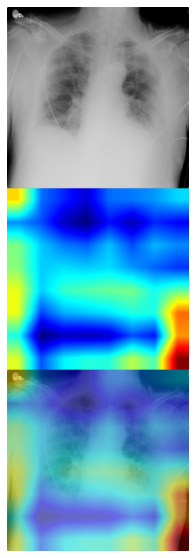

In [ ]:
# se afișează imaginea original, heatmap și rezultatul final (heatmap suprapus peste imagine)
# toate aceste 3 imagini sunt în format OpenCV, adică ordinea este BGR
# pentru afișare cu matplotlib canalele trebuie reordonate în RGB
display_output = np.vstack([orig[:, :, [2, 1, 0]], heatmap[:, :, [2, 1, 0]], output[:, :, [2, 1, 0]]])
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_axis_off()
ax.imshow(display_output)

# Resurse
- Deep Learning with Keras, de Francois Chollet
- [pyimagesearch blog - Grad-CAM](https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/)